# Introduction
In this project, we are working for the OilyGiant mining company.  Our task is to identify the most profitable region for oil well development.  We have exploration data with geologic features and oil reserves for 300,000 across 3 regions.  Using this data, we will develop a linear regression model to predict oil production.  We will combine the model with financial parameters and will use bootstrap methods to estimate the profit distribution for each region.  Using the profit distribution, we will describe the average profit and the risk of loss for each region.  Finally, based on these findings, we will recommend a region for development.

# Preliminary Data Review

In [1]:
from itertools import combinations
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')

random_state = 12345

try:
    df0 = pd.read_csv('geo_data_0.csv')
    df1 = pd.read_csv('geo_data_1.csv')
    df2 = pd.read_csv('geo_data_2.csv')
except:
    df0 = pd.read_csv('/datasets/geo_data_0.csv')
    df1 = pd.read_csv('/datasets/geo_data_1.csv')
    df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
df0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


We have a total of 300,000 records showing geologic featues and oil reserves for 3 regions.  Each record shows the following:

- <code>id</code>:  unique oil well identifier
- <code>f0</code>, <code>f1</code>, <code>f2</code>: well features
- <code>product</code>: volume of reserves in the oil well (thousand barrels)

## Conclusion
We have geological exploration data for 3 regions.  For each region, there 100,000 oil wells.  For each well, there are three features and <code>product</code>, the volume of reserves in the well (in thousands of barrels).  There are no missing values.  Data types are appropriate: <code>object</code> (string) for the well <code>id</code> and <code>float</code> for the features and <code>product</code>.

# Exploratory Data Analysis
In this section, we will examine the distribution of the features for each region, as well as the relationship of each feature to the volume of reserves.

In the plots below, each row represents a different region, and each column represents a different feature.

## Feature distributions

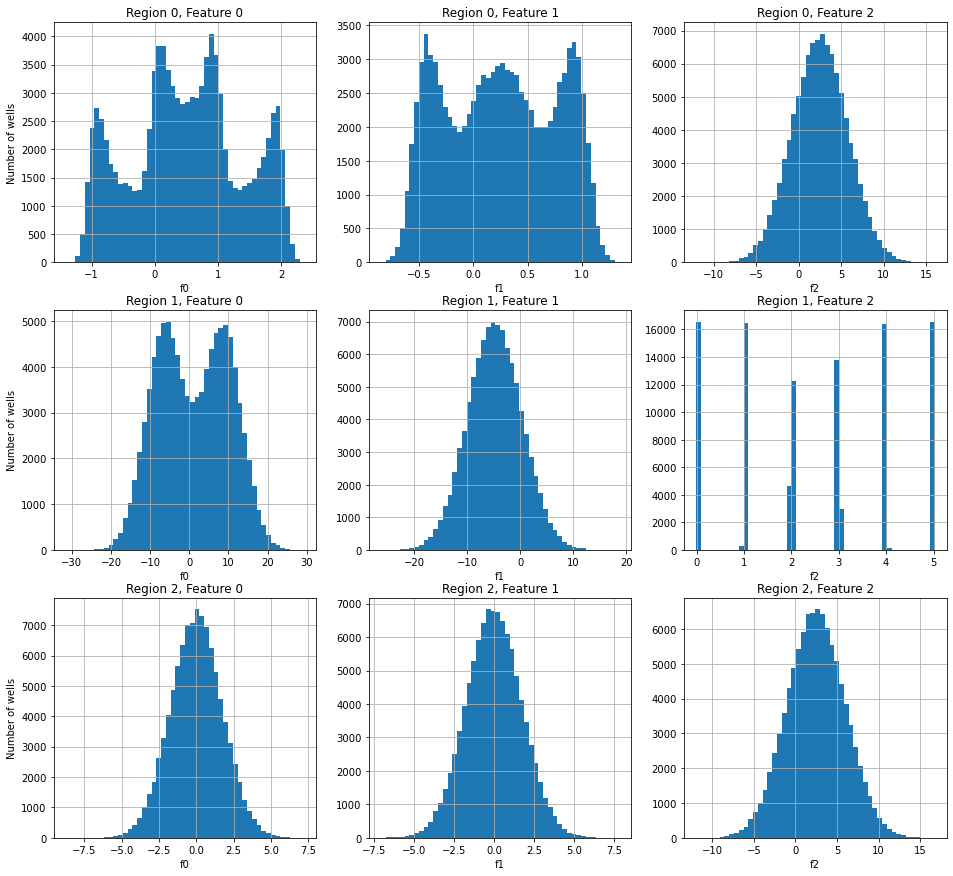

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(16, 15))
dfs = [df0, df1, df2]

for i in range(0, 3):
    for j in range(0, 3):
        axs[i, j].set_title('Region {}, Feature {}'.format(i, j))
        axs[i, j].hist(dfs[i]['f{}'.format(j)], bins=50)
        axs[i, j].set_xlabel('f{}'.format(j))
        if j == 0:
            axs[i, j].set_ylabel('Number of wells')
        axs[i, j].grid()

plt.show()

## Target/feature relationships

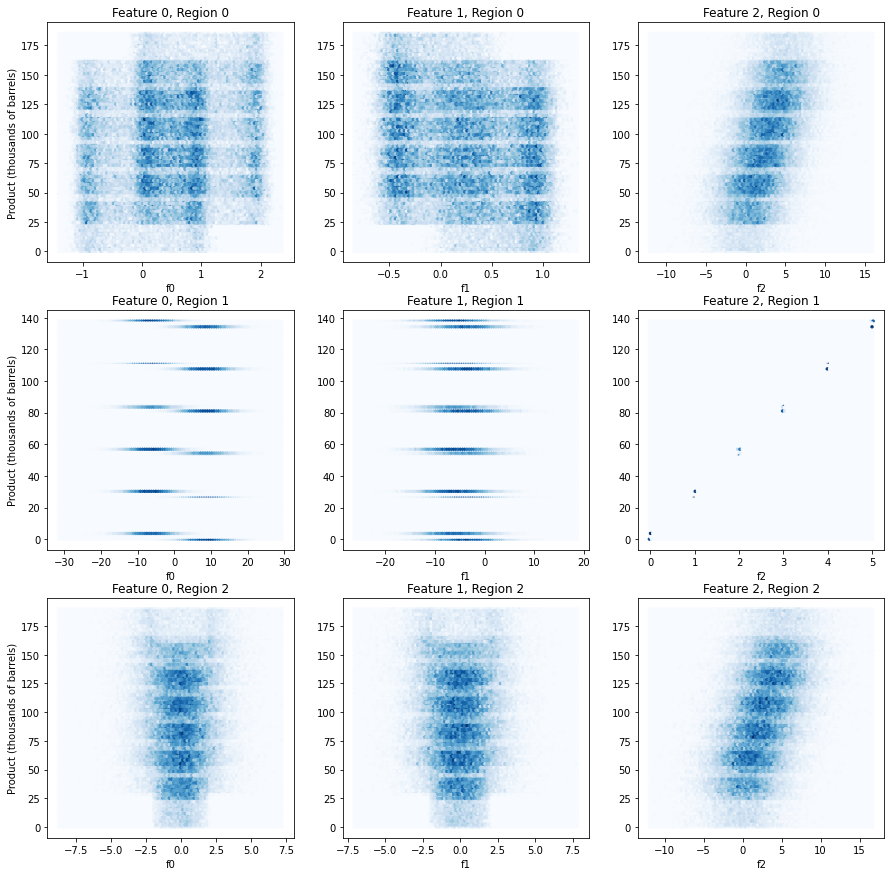

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i in range(0, 3):
    for j in range(0, 3):
        axs[i, j].set_title('Feature {}, Region {}'.format(j, i))
        axs[i, j].hexbin(dfs[i]['f{}'.format(j)], dfs[i]['product'], cmap='Blues')
        axs[i, j].set_xlabel('f{}'.format(j))
        if j == 0:
            axs[i, j].set_ylabel('Product (thousands of barrels)')

plt.show()

## Conclusion
- Feature names do not refer to the same thing in different regions, so it would be a mistake to combine the 3 data sets into a single data set.
- Some features have "well-behaved" distributions.  For instance, all of the featues in region 2 (the third row) are bell-shaped.  On the other hand, several features have multimodal distributions.  Feature 2 in region 1 is essentially a discrete variable.
- Most of the features are poorly correlated with our target, <code>product</code>.  A noteworthy exception is feature 2 (right-hand column), which shows a positive apparently linear correlation with our target.

# Model development
In this section, we will define the target and feature variables, split the data into training and test sets, perform feature scaling, and identify the set of features that produce the best model for each region.  Then we will fit the models using the training data and predict the targets using the test data.

## Target and feature variables

In [7]:
regions = []

for df_region in [df0, df1, df2]:
    region_data = {}
    region_data['X'] = df_region[['f0', 'f1', 'f2']]
    region_data['y'] = df_region[['product']]
    regions.append(region_data)

In [8]:
regions[0]['X'].head()

,f0,f1,f2
0,0.705745,-0.497823,1.221170
1,1.334711,-0.340164,4.365080
2,1.022732,0.151990,1.419926
3,-0.032172,0.139033,2.978566
4,1.988431,0.155413,4.751769


In [9]:
regions[0]['y'].head()

,product
0,105.280062
1,73.037750
2,85.265647
3,168.620776
4,154.036647


## Training and test data sets
For each region, we will split the data into a training set and test set at a ratio of 75:25.

In [10]:
for region in regions:
    region['X_train'], region['X_test'], region['y_train'], region['y_test'] = \
        train_test_split(region['X'], region['y'], train_size=0.75, 
                         random_state=random_state)
    region['X_train'].reset_index(inplace=True, drop=True)
    region['X_test'].reset_index(inplace=True, drop=True)
    region['y_train'].reset_index(inplace=True, drop=True)
    region['y_test'].reset_index(inplace=True, drop=True)

In [11]:
print('Training features: {} rows, {} columns\n           target: {} rows\n'.format(
    regions[0]['X_train'].shape[0], 
    regions[0]['X_train'].shape[1], 
    regions[0]['y_train'].shape[0]))
print('Test features: {} rows, {} columns\n       target: {} rows\n'.format(
    regions[0]['X_test'].shape[0], 
    regions[0]['X_test'].shape[1], 
    regions[0]['y_test'].shape[0]))

Training features: 75000 rows, 3 columns
           target: 75000 rows

Test features: 25000 rows, 3 columns
       target: 25000 rows



## Feature scaling
Feature scaling does not affect the performance of a linear regression model but can make it easire to compare regression coefficients.

In [12]:
for region in regions:
    scaler = StandardScaler()
    region['X_train_scaled'] = pd.DataFrame(scaler.fit_transform(region['X_train']),
                                            columns = ['f0','f1','f2'])
    region['X_test_scaled'] = pd.DataFrame(scaler.transform(region['X_test']),
                                           columns = ['f0','f1','f2'])

regions[0]['X_train_scaled'].head()

,f0,f1,f2
0,-0.544828,1.390264,-0.094959
1,1.455912,-0.480422,1.209567
2,0.260460,0.825069,-0.204865
3,-1.837105,0.010321,-0.147634
4,-1.299243,0.987558,1.273181


<div class="alert alert-block alert-success">
<b>Success:</b> Data was split correctly. Glad to see that scaler was fitted only on train part!
</div>

## Feature selection
With 3 features, there are only 7 combinations for each region, and we can perform an exhaustive search to select the best feature set, as measured by _adjusted r<sup>2</sup>_.

In [13]:
def adjusted_r2(r2, n, p):
    return 1 - (1-r2)*(n-1)/(n-p-1)

def root_mse(target, predicted):
    return mean_squared_error(target, predicted)**0.5

results = []

for i, region in enumerate(regions):
    for n in range(1, 4):
        for predictors in combinations(region['X_train_scaled'].columns, n):
            regressor = LinearRegression()
            regressor.fit(region['X_train_scaled'][list(predictors)], region['y_train'])
            region['y_hat'] = regressor.predict(region['X_test_scaled'][list(predictors)])
            
            rmse = root_mse(region['y_test'], region['y_hat'])
            r2 = r2_score(region['y_test'], region['y_hat'])
            adj_r2 = adjusted_r2(r2, len(region['y_hat']), len(list(predictors)))

            result = {}
            result['region'] = i
            result['features'] = ', '.join(list(predictors))
            result['rmse'] = rmse
            result['r2'] = r2
            result['adjusted_r2'] = adj_r2
            results.append(result)

results_df = pd.DataFrame(results).sort_values(['region', 'adjusted_r2'], ascending=False)
results_df.set_index(['region', 'features'])

rmse        r2  adjusted_r2
region features                                    
2      f2          40.029009  0.205275     0.205244
       f1, f2      40.029029  0.205275     0.205211
       f0, f2      40.029689  0.205248     0.205185
       f0, f1, f2  40.029709  0.205248     0.205152
       f1          44.902596 -0.000023    -0.000063
       f0          44.903269 -0.000053    -0.000093
       f0, f1      44.903515 -0.000064    -0.000144
1      f0, f1, f2   0.893099  0.999623     0.999623
       f0, f2       0.898842  0.999619     0.999619
       f1, f2       1.558094  0.998854     0.998854
       f2           1.594228  0.998800     0.998800
       f0          46.006841  0.000626     0.000586
       f0, f1      46.006958  0.000621     0.000541
       f1          46.020783  0.000020    -0.000020
0      f0, f1, f2  37.579422  0.279943     0.279857
       f1, f2      37.727586  0.274254     0.274196
       f0, f2      38.115915  0.259237     0.259178
       f2          38.729268  0.235205     0.235174
       f0, f1      43.293692  0.044313     0.044236
       f1          43.418299  0.038804     0.038765
       f0          43.762362  0.023509     0.023470

- The best models for regions 0 and 1 use all three features.
- Most of the predictive power for region 1 comes from feature 2.  As we saw in the EDA section, this feature has a strong linear correlation with our target.  Because of this feature, the _adjusted r<sup>2</sup>_ for region 1 is _much_ higher than for other regions.
- The best model for region 2 uses only feature 2.  The makes sense, as our hexbin plot showed a strong linear between f2 relationship to the target, and the other features for this region had little correlation with the target.

In [14]:
regions[0]['selected_X'] = ['f0', 'f1', 'f2']
regions[1]['selected_X'] = ['f0', 'f1', 'f2']
regions[2]['selected_X'] = ['f2']

In [15]:
for region in regions:
    regressor = LinearRegression()
    region['fitted_model'] = regressor.fit(region['X_train_scaled'][region['selected_X']], \
                                           region['y_train'])
    region['y_hat'] = pd.DataFrame(regressor.predict(region['X_test_scaled'][region['selected_X']]),
                                                    columns=['product'])

In [16]:
regions[0]['y_hat'].head()

,product
0,95.894952
1,77.572583
2,77.892640
3,90.175134
4,70.510088


## Conclusion
We developed a linear regression model for each region and used the models to predict our target, the oil reserves for each well.  In the next section, the fitted values will be used to develop a profit model.

# Profit Modeling
In this section, we will combine the fitted values from our models with financial parameters and use bootstrap methods to estimate the profit distribution for each region.

The situation we will simulate is as follows.  OilyGiant has data on the geologic features for 500 candidate wells in each region, but their budget supports the development of just 200 wells.  Using the predicted values from our models, we will select the top 200 wells among the 500 candidates.  Then, using the actual production data, we will calculate the profit generated by the 200 selected wells.  We will repeat this simulation 1,000 times, with 500 randomly selected wells each time, to develop a probability distribution for profit.  From the probability distribution, we will draw conclusions about profit and risk so that we can identify the most profitable region for development,

## Preparation
The budget for developing 200 oil wells is 100 million USD.  Each barrel produces 4.5 USD in revenue.  The <code>product</code> target variable in our model is in thousands of barrels, so each unit generates 4,500 USD.

The volume of reserves sufficient for developing a new well without losses is

\begin{equation}
\dfrac{$100,000,000}{200\,wells} = $500,000/well
\end{equation}

\begin{equation}
\dfrac{$500,000/well}{$4.50/barrel} = 111,111\,barrels/well
\end{equation}

How does this compare to the average reserves in each region?

In [17]:
region_average_reserves = {
    'Region 0' : [df0['product'].mean()],
    'Region 1' : [df1['product'].mean()],   
    'Region 2' : [df2['product'].mean()]    
}
pd.DataFrame(region_average_reserves)

,Region 0,Region 1,Region 2
0,92.5,68.825,95.0


The average reserves in each region is less than the break-even number for barrels.  If our model just randomly selected wells, production would average 85 thousand barrels (the average production across the 3 regions), which equates to a loss of about \$23.5 million.  It is important that our model select the most profitable wells.  How good does our model have to be?

In [18]:
# inverse of quantile
stats.percentileofscore(df1['product'], 111)

83.463

In region 1, for example, our model must identify at least the 83rd percentile, or top 17%, of wells, on average, in order to break even.

Next, we well define key parameters for estimating the regional profit distribution.

In [19]:
NUM_CANDIDATES = 500     # Number of wells considered for development
NUM_SELECTED = 200       # Number of wells selected by our model
NUM_TRIALS = 1000        # Number of trials for bootstrap calculations
DEVELOPMENT_COST = 1e8   # Cost to develop 200 wells
REVENUE_PER_1000 = 4500  # Revenue per unit of product

## Regional profit distribution

In [20]:
def revenue(target, predicted, count):
    predicted_sorted = predicted.sort_values(by='product', ascending=False)
    selected = target.loc[predicted_sorted.index][:count]
    return selected['product'].sum(), REVENUE_PER_1000 * selected['product'].sum()

In [21]:
state = np.random.RandomState(random_state)
regions_volume = {}
regions_profit = {}
    
for i, region in enumerate(regions):
    volumes = []
    revenues = []
    for _ in range(NUM_TRIALS):
        target_subsample = region['y_test'].sample(n=NUM_CANDIDATES, replace=True, random_state=state)
        predicted_subsample = region['y_hat'].iloc[target_subsample.index]
        vol, rev = revenue(target_subsample, predicted_subsample, NUM_SELECTED)
        volumes.append(vol)
        revenues.append(rev)    

    regions_volume[f'Region {i}'] = volumes
    
    # Calculate profit in millions of USD
    regions_profit[f'Region {i}'] = [(r - DEVELOPMENT_COST)/1e6 for r in revenues]

### Production volume

In [22]:
volume_df = pd.DataFrame(regions_volume)
volume_df.describe()

,Region 0,Region 1,Region 2
count,1000.000000,1000.000000,1000.000000
mean,23168.752282,23373.909986,23159.368542
std,616.170494,465.883420,631.581090
min,21384.793983,21910.789669,21280.853300
25%,22743.258990,23058.722145,22705.030297
50%,23157.049491,23356.728457,23149.437826
75%,23598.397879,23675.848156,23611.612239
max,25355.203695,24835.840489,25545.802888


The table above summarizes the production volume for our 200 selected wells, across 1,000 trials.  If wells were selected at random, we would expect to see average production ranging from about 68 for Region 1 to 95 for Region 2.  Our model is doing better than that, and is also exceeding the break-even production of 111 barrels per well (which equates to 222,222 barrels per 200 wells in the table above.)  Next, we will examine the profits associated with these production volumes.

### Profit

In [23]:
profit_df = pd.DataFrame(regions_profit)
profit_df.describe()

,Region 0,Region 1,Region 2
count,1000.000000,1000.000000,1000.000000
mean,4.259385,5.182595,4.217158
std,2.772767,2.096475,2.842115
min,-3.768427,-1.401446,-4.236160
25%,2.344665,3.764250,2.172636
50%,4.206723,5.105278,4.172470
75%,6.192790,6.541317,6.252255
max,14.098417,11.761282,14.956113


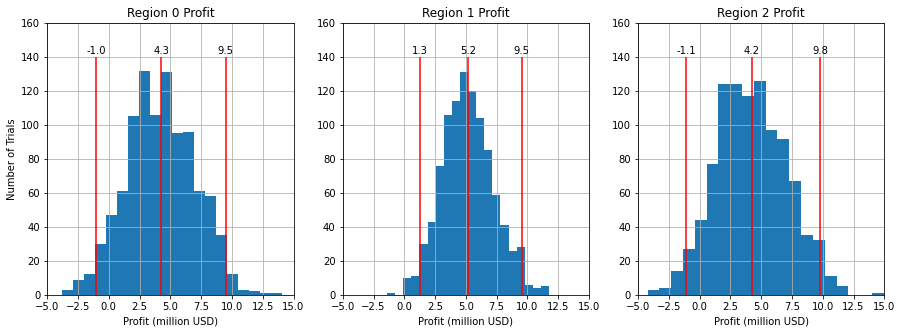

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for region, profit in profit_df.iteritems():
    j = profit_df.columns.get_loc(region)
    axs[j].set_title(f'{region} Profit')
    axs[j].hist(profit, bins=20)
    axs[j].set_xlabel('Profit (million USD)')
    if j == 0:
        axs[j].set_ylabel('Number of Trials')
    axs[j].set_xlim(-5, 15)
    axs[j].set_ylim(0, 160)
    axs[j].grid()
    
    mean = profit.mean()
    axs[j].vlines(mean, 0, 140, colors='red')
    axs[j].text(mean, 142, f'{mean:.1f}', horizontalalignment='center')
    
    profit_lower = profit_df[region].quantile(0.025)
    profit_upper = profit_df[region].quantile(0.975)
    axs[j].vlines([profit_lower, profit_upper], 0, 140, colors='red')
    axs[j].text(profit_lower, 142, f'{profit_lower:.1f}', horizontalalignment='center')
    axs[j].text(profit_upper, 142, f'{profit_upper:.1f}', horizontalalignment='center')
    
plt.show()

- Region 1 produces the highest expected profit at \$5.2 million, 95\% CI [1.3, 9.5].  The risk of loss for Region 1 is less than OilyGiant's risk tolerance threshold of 2.5\%.
- Both Regions 0 and 2 produced lower expected profits, and in each of these regions, the risk 
of loss was greater than 2.5\%.  In particular:
    - Region 0 produced an expected a profit of \$4.3 million, 95\% CI [-1.0, 9.5].
    - Region 2 produced an expected profit of \$4.2 million, 95\% CI [-1.1, 9.8].

In the following section, we will examine the expected profit and risk of loss in greater detail.

## Risk analysis
In this section, we will use the profit distributions to derive bootstrap confidence intervals around the mean profit and the risk of loss.

### 95% confidence interval for mean profit

In [26]:
regions_mean_profit = {}

for region, profits in profit_df.iteritems():
    mean_profits = []
    for _ in range(NUM_TRIALS):
        profit_subsample = profits.sample(n=len(profit_df), replace=True, random_state=state)
        mean_profits.append(profit_subsample.mean())

    regions_mean_profit[region] = mean_profits

In [27]:
mean_profit_df = pd.DataFrame(regions_mean_profit)
mean_profit_df.describe()

,Region 0,Region 1,Region 2
count,1000.000000,1000.000000,1000.000000
mean,4.261581,5.182859,4.220020
std,0.087055,0.064344,0.090818
min,4.020047,4.988322,3.925822
25%,4.203642,5.140842,4.162055
50%,4.260961,5.181611,4.221451
75%,4.321805,5.227426,4.277328
max,4.514468,5.379744,4.493330


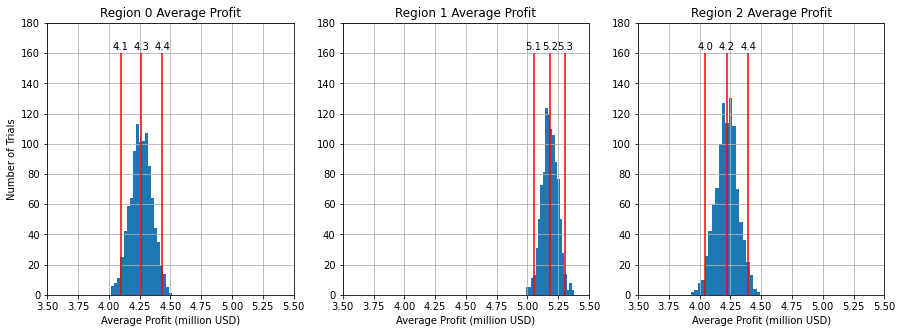

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for region, mean_profit in mean_profit_df.iteritems():
    j = mean_profit_df.columns.get_loc(region)
    axs[j].set_title(f'{region} Average Profit')
    axs[j].hist(mean_profit, bins=20)
    axs[j].set_xlabel('Average Profit (million USD)')
    if j == 0:
        axs[j].set_ylabel('Number of Trials')
    axs[j].set_xlim(3.5, 5.5)
    axs[j].set_ylim(0, 180)
    axs[j].grid()
    
    ci_lower = mean_profit.quantile(0.025)
    ci_upper = mean_profit.quantile(0.975)
    axs[j].vlines([ci_lower, ci_upper], 0, 160, colors='red')
    axs[j].text(ci_upper, 162, f'{ci_upper:.1f}', horizontalalignment='center')
    axs[j].text(ci_lower, 162, f'{ci_lower:.1f}', horizontalalignment='center')
    
    mean = mean_profit.mean()
    axs[j].vlines(mean, 0, 160, colors='red')
    axs[j].text(mean, 162, f'{mean:.1f}', horizontalalignment='center')

plt.show()

In the figures above, the red lines show the mean profit, with confidence intervals, derived from 1,000 bootstrap trials from the profit distribution.

- The mean profit for Region 0 is \$4.3 million, 95\% CI [4.1-4.4].
- The mean profit for Region 1 is \$5.2 million, 95\% CI [5.1-5.3].
- The mean profit for Region 2 is \$4.2 million, 95\% CI [4.0-4.4].

### 95% confidence interval for break-even percentile

In this section, we examine the risk of loss in each region.

In [29]:
regions_breakeven = {}

for region, profits in profit_df.iteritems():
    breakeven = []
    for _ in range(NUM_TRIALS):
        profit_subsample = profits.sample(n=len(profit_df), replace=True, random_state=state)
        breakeven.append(stats.percentileofscore(profit_subsample, 0))

    regions_breakeven[region] = breakeven

In [30]:
breakeven_df = pd.DataFrame(regions_breakeven)
breakeven_df.describe()

,Region 0,Region 1,Region 2
count,1000.000000,1000.000000,1000.000000
mean,6.055000,0.290900,5.731700
std,0.744103,0.171746,0.738682
min,3.900000,0.000000,3.600000
25%,5.600000,0.200000,5.200000
50%,6.000000,0.300000,5.700000
75%,6.500000,0.400000,6.200000
max,9.000000,0.900000,8.200000


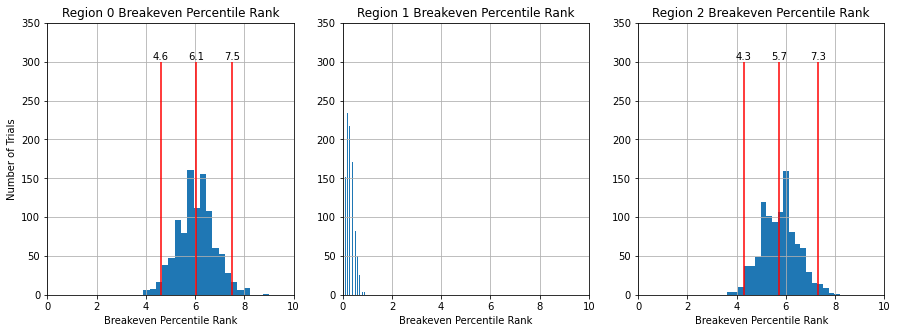

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for region, breakeven_pr in breakeven_df.iteritems():
    j = breakeven_df.columns.get_loc(region)
    axs[j].set_title(f'{region} Breakeven Percentile Rank')
    axs[j].hist(breakeven_pr, bins=20)
    axs[j].set_xlabel('Breakeven Percentile Rank')
    if j == 0:
        axs[j].set_ylabel('Number of Trials')
    axs[j].set_xlim(0, 10)
    axs[j].set_ylim(0, 350)
    axs[j].grid()
    
    if j != 1:
        ci_lower = breakeven_pr.quantile(0.025)
        ci_upper = breakeven_pr.quantile(0.975)
        axs[j].vlines([ci_lower, ci_upper], 0, 300, colors='red')
        axs[j].text(ci_upper, 302, f'{ci_upper:.1f}', horizontalalignment='center')
        axs[j].text(ci_lower, 302, f'{ci_lower:.1f}', horizontalalignment='center')
    
        mean = breakeven_pr.mean()
        axs[j].vlines(mean, 0, 300, colors='red')
        axs[j].text(mean, 302, f'{mean:.1f}', horizontalalignment='center')

plt.show()

The figures above show the risk of sustaining a loss in each region.  The risk of loss in Region 1 is almost 0.

The risk of loss in Regions 0 and 2 exceeds OilyGiant's risk tolerance level:
- The risk of loss in Region 0 is 6.1\%, 95% CI [4.6, 7.5].
- The risk of loss in Region 2 in 5.7\%, 95% CI [4.3-7.3].


## Conclusion
With the highest expected profit at \$5.2 million, 95\% CI [1.3, 9.5], and almost no risk of loss, Region 1 is the easy winner.  Both Regions 0 and 2 offer lower expected profits and a higher risk of loss of about 6\%, which exceeds OilyGiant's risk tolerance threshold.

# Conclusion and Recommendations

In this project, we developed a model to predict oil reserves and estimated profit for OilyGiant.  We found that Region 1 offers the highest expected profit and almost no risk of loss.  Although this region had the lowest average reserves, our model was able to identify the most profitable wells with a high degree of accuracy thanks to feature 2, which was highly correlated with reserves.